# Painting classifier project

This is the notebook I used to train my model and do some tests.
 
Please read the readme file in my github project for additional information : link

## Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
from shutil import copy2
import csv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
#!pip install tensorflow_hub

In [7]:
import tensorflow_hub as hub

In [10]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [11]:
#path to my drive folder containing the images
root = ("/content/drive/My Drive/dl_project/photos-appareil/images")

## Parameters for the data augmentation

In [13]:
IMAGE_SIZE = 224

IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

TRAINING_DATA_DIR = str(root) 

datagen_kwargs = dict(
    rescale=1./255, 
    validation_split=0.2, #percentage train/val 
    rotation_range=360,
    zoom_range=[0.5,1.2],
    shear_range = 0.15,
    width_shift_range=0.25,
    height_shift_range=0.25,
    brightness_range=[0.75,1.5] #vary light intensity
    )  #nearly all excluding flips, since this is not possible for this use

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE,
    save_to_dir = "/content/drive/My Drive/dl_project/photos-appareil/augmented",
    #to have some examples of the augmented data 
    save_prefix='aug'
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE,
#    save_to_dir = "/content/drive/My Drive/dl_project/photos-appareil/augmented", 
#    save_prefix='aug',
)

Found 1228 images belonging to 55 classes.
Found 5017 images belonging to 55 classes.


## Define and train the model

In [ ]:
#transfer learning

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 55)                70455     
Total params: 2,328,439
Trainable params: 70,455
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [ ]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/20
157/157 [==============================] - 4102s 26s/step - loss: 1.8514 - acc: 0.5627 - val_loss: 0.8313 - val_acc: 0.8607
Epoch 2/20
157/157 [==============================] - 289s 2s/step - loss: 0.4097 - acc: 0.9155 - val_loss: 0.4241 - val_acc: 0.9235
Epoch 3/20
157/157 [==============================] - 289s 2s/step - loss: 0.2255 - acc: 0.9605 - val_loss: 0.3322 - val_acc: 0.9381
Epoch 4/20
157/157 [==============================] - 288s 2s/step - loss: 0.1558 - acc: 0.9701 - val_loss: 0.2529 - val_acc: 0.9495
Epoch 5/20
157/157 [==============================] - 288s 2s/step - loss: 0.1269 - acc: 0.9743 - val_loss: 0.2370 - val_acc: 0.9568
Epoch 6/20
157/157 [==============================] - 288s 2s/step - loss: 0.0949 - acc: 0.9817 - val_loss: 0.1938 - val_acc: 0.9601
Epoch 7/20
157/157 [==============================] - 288s 2s/step - loss: 0.0810 - acc: 0.9860 - val_loss: 0.1657 - val_acc: 0.9699
Epoch 8/20
157/157 [==============================] - 290s 2s/step 

In [ ]:
model.save("/content/drive/My Drive/dl_project/my_model_0310_3")

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator,
                                            steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

39/39 [==============================] - 69s 2s/step - loss: 0.0758 - acc: 0.9788
Final loss: 0.08
Final accuracy: 97.88%


## Visualizing the data

This part was done to visualize some results.
I used a lot of Aryan Pegwar's code available in his Medium article, cited in the readme file.



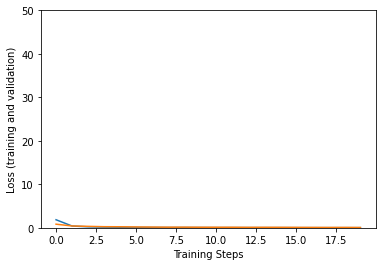

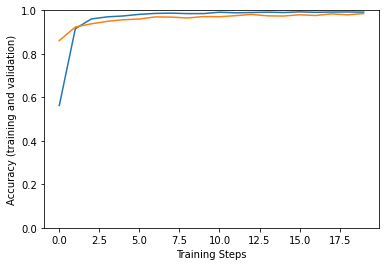

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
#for the visualisation in the "Model predictions" grid
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)  
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(),
                        key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])

In [ ]:
tf_model_predictions = model.predict(val_image_batch)
#print("Prediction results shape:", tf_model_predictions.shape)

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
#print(predicted_labels)

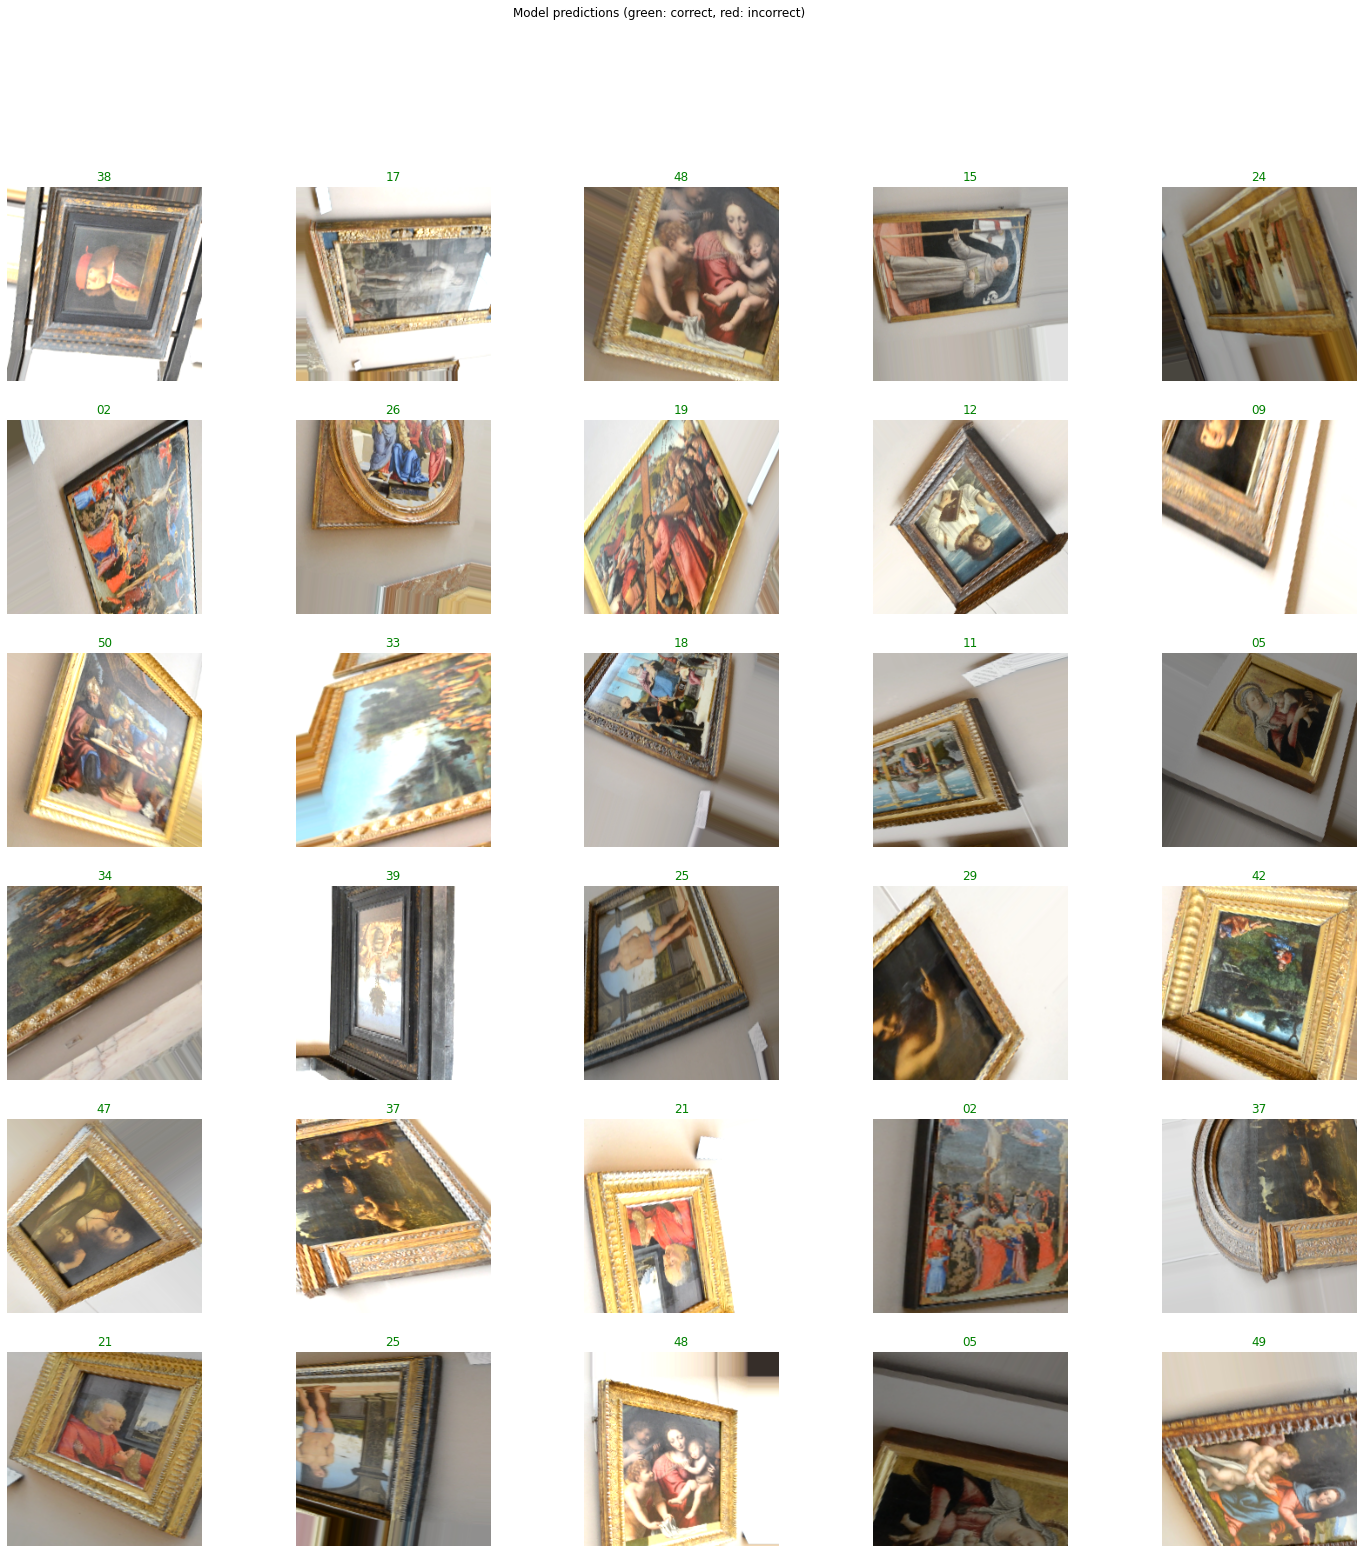

In [ ]:
plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.2)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Try my model on the test data

In [1]:
#if we only do this part

from tensorflow import keras
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os

In [2]:
model = keras.models.load_model('/content/drive/My Drive/dl_project/my_model_0310_3')

In [ ]:
#my drive folder containing my test data
PATH = "/content/drive/My Drive/dl_project/photos-iphone/"
files = os.listdir(PATH)

In [ ]:
#some strings inside because sometimes 2 paintings on one picture
correct_answers = [1,1,2,2,3,5,4,6,9,7,8,"10/9",10,11,"14/13",15,15,"14/13",16,
                   16,17,18,17,16,19,19,20,21,22,"23/24","23/24",20,"23/24",25,
                   25,26,26,27,28,29,30,31,32,"31/","32/31","33/32",33,34,35,36,
                   37,38,39,40,40,41,43,42,43,44,45,46,47,48,49,50,51,53,53,54,
                   52,52]

In [ ]:
#comparison with expected results done by hand because it's interesting to see 
#where are the errors

for i,f in enumerate(files): 
  image_path = os.path.join(PATH, f)
  img = cv2.imread(image_path)
  #cv2_imshow(img)
  img = cv2.resize(img,(224,224))
  img = np.reshape(img,[1,224,224,3])
  img = img / 255.0
  classes = model.predict_classes(img)
  res = model.predict(img)

  top_values_index = sorted(range(len(res[0])), key=lambda i: res[0][i])[-3:]
  prob = []
  for j in top_values_index:
    prob = prob + [res[0][j]] 

  #because the first picture is 1 and not 0
  top_values_index_modified = [x + 1 for x in top_values_index] 

  print(i+1, ") " , top_values_index_modified, " correct_ans:",correct_answers[i]) 
  #[::-1] to get the list in reversed order


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


1 )  [4, 16, 1]  ans: 1
2 )  [4, 20, 1]  ans: 1
3 )  [18, 52, 2]  ans: 2
4 )  [22, 52, 2]  ans: 2
5 )  [16, 4, 3]  ans: 3
6 )  [20, 5, 4]  ans: 5
7 )  [4, 6, 29]  ans: 4
8 )  [37, 12, 26]  ans: 6
9 )  [10, 29, 9]  ans: 9
10 )  [37, 36, 7]  ans: 7
11 )  [40, 8, 12]  ans: 8
12 )  [41, 13, 10]  ans: 10/9
13 )  [9, 12, 10]  ans: 10
14 )  [16, 18, 11]  ans: 11
15 )  [16, 20, 14]  ans: 14/13
16 )  [22, 12, 15]  ans: 15
17 )  [12, 22, 15]  ans: 15
18 )  [10, 14, 32]  ans: 14/13
19 )  [17, 18, 16]  ans: 16
20 )  [31, 17, 16]  ans: 16
21 )  [17, 16, 18]  ans: 17
22 )  [16, 13, 18]  ans: 18
23 )  [47, 17, 28]  ans: 17
24 )  [37, 17, 16]  ans: 16
25 )  [11, 18, 16]  ans: 19
26 )  [36, 12, 16]  ans: 19
27 )  [40, 53, 20]  ans: 20
28 )  [35, 36, 12]  ans: 21
29 )  [40, 37, 16]  ans: 22
30 )  [12, 13, 16]  ans: 23/24
31 )  [41, 14, 16]  ans: 23/24
32 )  [34, 16, 12]  ans: 20
33 )  [11, 16, 41]  ans: 23/24
34 )  [12, 18, 25]  ans: 25
35 )  [12, 28, 25]  ans: 25
36 )  [20, 14, 26]  ans: 26
37 )  [22, 

# What I want my app to do

In [7]:
#imports
import cv2
import numpy as np
from tensorflow import keras

from google.colab.patches import cv2_imshow #just to visualize

model = keras.models.load_model('/content/drive/My Drive/dl_project/my_model_0310_3')

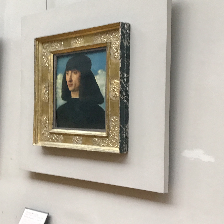

In [8]:
# prediction on 1 painting

image_path = '/content/drive/My Drive/dl_project/photos-iphone/IMG_3548.JPG'
img = cv2.imread(image_path)
img = cv2.resize(img,(224,224))
cv2_imshow(img) #just to see it
img = np.reshape(img,[1,224,224,3])
img = img / 255.0
#classes = model.predict_classes(img)
res = model.predict(img)

In [9]:
top_values_index = sorted(range(len(res[0])), key=lambda i: res[0][i])[-3:]
prob = []
for i in top_values_index:
  prob = prob + [res[0][i]]

#because the first picture is 1 and not 0
top_values_index_modified = [x + 1 for x in top_values_index] 
  

In [10]:
print("Top 3 possibilities:" , top_values_index_modified[::-1])
#[::-1] to get the list in reversed order, and have the top 1 in first
print("Probabilities:", prob[::-1])

Top 3 possibilities: [10, 12, 9]
Probabilities: [0.9470318, 0.014821396, 0.010808244]


Here the model predicts that the picture is the class 10 at 95%, which is the correct answer. This is very good result obtained from a picture the model haven't seen during the training.